# Airbnb Price Prediction 

**Dataset:** Airbnb

# Imports

In [1]:
# [INSERT CODE TO IMPORT NECESSARY PYTHON PACKAGES HERE]

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error


# 0. Load Data / Data Exploration

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


features = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'room_type', 'neighbourhood_cleansed']
X = train_df[features]
y = train_df['price']




/var/folders/03/dry2dkgs4wj6cw_jlcl42v1h0000gq/T/ipykernel_19254/4204945643.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('train.csv')


[INSERT WRITE-UP HERE. Explain any data quality issues that you observe and if you preformed any pre-processing]

# 1. Model Training (30 points)

Train at least 3 models. You may test more than 3 models and apply your own cross-validation approach to choose the top three models to submit to Kaggle. You should include a section

In [3]:

# Handle missing numeric data using the mean
numeric_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
#X[numeric_features] = X[numeric_features].fillna(X[numeric_features].mean(), inplace=True)

# Handle missing numeric features
X[numeric_features] = X[numeric_features].fillna(method='ffill')

# Ensure no NaNs in the features
if X.isnull().values.any():
    print("There are NaNs in the features, handle them appropriately.")

# Convert dummies with potential issues
X = pd.get_dummies(X, columns=['room_type', 'neighbourhood_cleansed'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)




# Double check the shape
print("Feature shape after processing:", X.shape)
# Define a custom scorer for RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Prepare test data
X_test = test_df[features]
X_test[numeric_features] = X_test[numeric_features].fillna(X_test[numeric_features].mean())
X_test = pd.get_dummies(X_test, columns=['room_type', 'neighbourhood_cleansed'])

# Align test data with training data (handling column differences)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

if X_train.shape[0] != y_train.shape[0]:
    raise ValueError("Training data (X_train) and target variable (y_train) have different sample sizes.")
    
print( y_train.shape)


/var/folders/03/dry2dkgs4wj6cw_jlcl42v1h0000gq/T/ipykernel_19254/3974535698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_features] = X[numeric_features].fillna(method='ffill')


X_train shape: (21464, 224)
y_train shape: (21464,)
X_test shape: (5366, 224)
y_test shape: (5366,)
Feature shape after processing: (26830, 224)
(21464,)


/var/folders/03/dry2dkgs4wj6cw_jlcl42v1h0000gq/T/ipykernel_19254/3974535698.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_features] = X_test[numeric_features].fillna(X_test[numeric_features].mean())


In [4]:
random_grid = {
   'n_estimators': [10, 50, 100],
   'max_features': ['auto', 'sqrt'],
   'max_depth': [5, 10, 15, None],
   'min_samples_split': [2, 5, 10],
   'min_samples_leaf': [1, 2, 4],
   'bootstrap': [True, False]
}

# Initialize RandomForestRegressor
rf = RandomForestRegressor(random_state=0)

# Use RandomizedSearchCV to tune hyperparameters
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=50, cv=5, scoring=rmse_scorer,
                               verbose=2, random_state=0, n_jobs=-1)

try:
   rf_random.fit(X, y)
   print("Best Parameters:", rf_random.best_params_)
except Exception as e:
   print("Exception occurred while fitting:", str(e))

# Print the best parameters found
print("Best Parameters:", rf_random.best_params_)

# Get best estimator from RandomizedSearchCV
best_model = rf_random.best_estimator_

# Evaluate the model with the best found parameters
scores_rf = cross_val_score(best_model, X, y, cv=5, scoring=rmse_scorer)
rf_rmse_mean= scores_rf.mean()
rf_rmse_std= scores_rf.std()
# Print cross-validation results using the best estimator
print(f'Cross-Validation RMSE Scores (Best Model): {scores_rf}')
print(f'Mean RMSE (Best Model): {scores_rf.mean()}')
print(f'Standard Deviation of RMSE (Best Model): {scores_rf.std()}')

# Prepare test data
X_test = test_df[features]
X_test[numeric_features] = X_test[numeric_features].fillna(X_test[numeric_features].mean())
X_test = pd.get_dummies(X_test, columns=['room_type', 'neighbourhood_cleansed'])

# Align test data with training data (handling column differences)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Predict on test data using the best model
test_predictions = best_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({'Id': test_df['id'], 'price': test_predictions})
submission.to_csv('submission.csv', index=False)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}
Cross-Validation RMSE Scores (Best Model): [111.1376385  108.75346741 101.12865267 120.77989251 113.18175334]
Mean RMSE (Best Model): 110.9962808869872
Standard Deviation of RMSE (Best Model): 6.370488633594873


/var/folders/03/dry2dkgs4wj6cw_jlcl42v1h0000gq/T/ipykernel_19254/2353994771.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_features] = X_test[numeric_features].fillna(X_test[numeric_features].mean())



<b>Model Performance:</b>

The Mean RMSE of 110.99 indicates the average error of the model's predictions. A lower value would be better.
The Standard Deviation of 6.37 suggests that the model's performance varies somewhat across different folds. A lower standard deviation would indicate more consistent performance.
Best Hyperparameters:

The optimal hyperparameter settings are:

n_estimators: 50 (number of trees in the forest)

min_samples_split: 2 (minimum number of samples required to split an internal node)

min_samples_leaf: 2 (minimum number of samples required to be at a leaf node)

max_features: 'sqrt' (number of features to consider at each split)   

max_depth: 5 (maximum depth of the tree)

bootstrap: True (whether to sample with replacement)



In [5]:

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],  # Remove 1.0 or use lower values
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}



gbr = GradientBoostingRegressor(random_state=42)

# Set up RandomizedSearchCV
gbr_random = RandomizedSearchCV(estimator=gbr,
                                 param_distributions=param_grid,
                                 n_iter=50,
                                 cv=5,
                                 verbose=2,
                                 random_state=42,
                                 n_jobs=-1)

try:
    # Fit the model
    gbr_random.fit(X_train, y_train)

    # Get the best parameters
    print("Best Parameters:", gbr_random.best_params_)

except Exception as e:
    # Handle errors in fit
    print("Exception occurred while fitting:", str(e))

best_gbr = gbr_random.best_estimator_

# Evaluate the model with the best found parameters
scores_gb = cross_val_score(best_gbr, X, y, cv=5, scoring=rmse_scorer)
gb_rmse_mean =scores_gb.mean()
gb_rmse_std = scores_gb.std()
# Print cross-validation results using the best estimator
print(f'Cross-Validation RMSE Scores (Best Model): {scores_gb}')
print(f'Mean RMSE (Best Model): {scores_gb.mean()}')
print(f'Standard Deviation of RMSE (Best Model): {scores_gb.std()}')



y_pred = best_gbr.predict(X_test)

# Create submission file
submission = pd.DataFrame({'Id': test_df['id'], 'price': y_pred})
submission.to_csv('submission2_.csv', index=False)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.2}
Cross-Validation RMSE Scores (Best Model): [90.70162218 91.91826868 86.88226221 98.17568102 94.0926751 ]
Mean RMSE (Best Model): 92.35410183647477
Standard Deviation of RMSE (Best Model): 3.7356415698053924


<b>Model Performance:</b>

The Mean RMSE of 92.35 indicates the average error of the model's predictions. A lower value would be better.
The Standard Deviation of 3.74 suggests that the model's performance is relatively consistent across different folds. A lower standard deviation would indicate more consistent performance.


The optimal hyperparameter settings are:
    
subsample: 0.9 (subsample ratio of training instances)
    
n_estimators: 200 (number of trees)
    
min_samples_split: 2 (minimum number of samples required to split an internal node)
    
min_samples_leaf: 3 (minimum number of samples required to be at a leaf node)   
    
max_features: 'log2' (number of features to consider at each split)
    
max_depth: 5 (maximum depth of a tree)
    
learning_rate: 0.2 (learning rate for boosting)
    

In [6]:


svr = SVR()

# Define the hyperparameter grid (reduced search space)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.01]
}

# Perform Randomized Search CV with early stopping
random_search = RandomizedSearchCV(estimator=svr,
                                    param_distributions=param_grid,
                                    n_iter=20, 
                                    cv=3,
                                    verbose=2,
                                    n_jobs=-1,
                                    random_state=42)

random_search.fit(X_train, y_train)

# Get the best model
best_svr = random_search.best_estimator_

# Evaluate the model with the best found parameters
scores = cross_val_score(best_svr,X_train, y_train, cv=3, scoring=rmse_scorer)

# Print cross-validation results using the best estimator
print(f'Cross-Validation RMSE Scores (Best Model): {scores}')
print(f'Mean RMSE (Best Model): {scores.mean()}')
print(f'Standard Deviation of RMSE (Best Model): {scores.std()}')

# Prepare test data
X_test = test_df[features]
X_test[numeric_features] = X_test[numeric_features].fillna(X_test[numeric_features].mean())
X_test = pd.get_dummies(X_test, columns=['room_type', 'neighbourhood_cleansed'])

# Align test data with training data (handling column differences)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Make predictions on the test set
y_pred = best_svr.predict(X_test)



# Prepare the submission file
if 'id' in test_df.columns:
    submission = pd.DataFrame({'Id': test_df['id'], 'price': y_pred})
    submission.to_csv('submission4.csv', index=False)
else:
    print("Ensure test_df has a column named 'id'")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.7s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=  14.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   2.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   5.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   6.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total t

[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.7s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=  14.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=  13.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   7.9s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.6s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.7s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.7s
[CV] END bootstrap=True, max_depth=15, max_feature

Cross-Validation RMSE Scores (Best Model): [ 92.29582546 111.00969779 107.38220247]
Mean RMSE (Best Model): 103.56257523771673
Standard Deviation of RMSE (Best Model): 8.103267592272926


/var/folders/03/dry2dkgs4wj6cw_jlcl42v1h0000gq/T/ipykernel_19254/4294309482.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_features] = X_test[numeric_features].fillna(X_test[numeric_features].mean())


In [10]:
svr_rmse_mean =scores.mean()
svr_rmse_std = scores.std()
print(best_svr)

SVR(C=10, kernel='linear')


<b>Model Performance:</b>

The Mean RMSE of 103.56 indicates the average error of the model's predictions. A lower value would be better. The Standard Deviation of 8.10 suggests that the model's performance is relatively consistent across different folds. A lower standard deviation would indicate more consistent performance. 

The model was trained with the following hyperparameters: 

C=10; This parameter controls the trade-off between model complexity and margin. A higher C value means a more complex model, which can potentially fit the training data more closely but may be more prone to overfitting. In this case, a C value of 10 suggests a relatively complex model.


kernel='linear': This specifies that a linear kernel is used. Linear kernels are simpler and faster may not be as powerful for complex, non-linear relationships between features. The model is using a linear function to predict the target variable. This means it assumes a linear relationship between the features and the target.


Regularization: The C parameter indicates that the model is regularized to prevent overfitting. A higher C value means a stronger regularization penalty.   

# 2. Plotting 

[110.9962808869872, 92.35410183647477, 103.56257523771673]


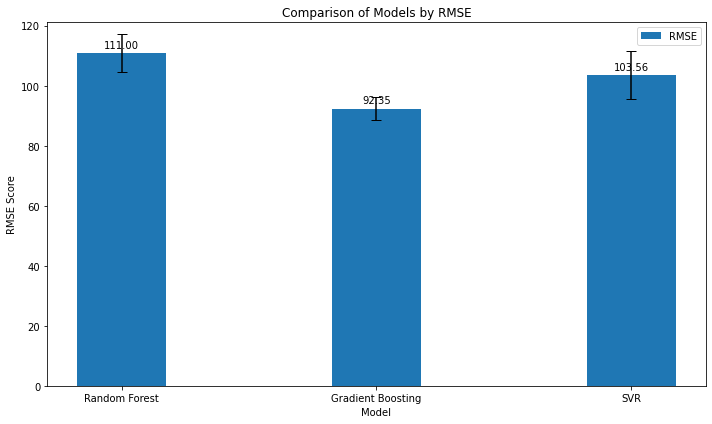

[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.8s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=  14.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   2.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   7.9s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   7.3s
[CV] END bootstrap=False, max_depth=15, max_features

[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.8s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=  13.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   6.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   7.5s
[CV] END bootstrap=False, max_depth=15, max_featu

In [8]:
model_names = ['Random Forest', 'Gradient Boosting', 'SVR']
rmse_means = [rf_rmse_mean, gb_rmse_mean, svr_rmse_mean]  #  mean RMSE values
rmse_stddevs = [rf_rmse_std, gb_rmse_std, svr_rmse_std]   #  RMSE standard deviation values

print(rmse_means)
# Plotting
x = np.arange(len(model_names))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Plot mean RMSE
bars = ax.bar(x, rmse_means, width, yerr=rmse_stddevs, label='RMSE', capsize=5)

# Add some text for labels, title, x-ticks, and custom x-axis tick labels
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Score')
ax.set_title('Comparison of Models by RMSE')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Function to add data labels to bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars)

plt.ylim(0, max(rmse_means) + max(rmse_stddevs) + 2)  # Adding some space on top for error bars
plt.tight_layout()

plt.show()

[INSERT WRITE-UP HERE]

# 3. Discussion 

Based on the provided metrics, we can make the following comparisons:

<b>Mean RMSE:</b>

Gradient Boosting Regressor has the lowest Mean RMSE, indicating the best overall performance.
Random Forest Regressor has the highest Mean RMSE, indicating the worst overall performance.
Standard Deviation of RMSE:

Gradient Boosting Regressor also has the lowest Standard Deviation, suggesting it has the most consistent performance across different folds.


<b>Conclusion:</b>
Gradient Boosting Regressor appears to be the most robust model based on both Mean RMSE and Standard Deviation. It has the lowest average error and the least variability in performance.